In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

# 原始输入数据: [T_air (degC), I_D (W/m^2), R_L (ohms)]
xdata = [
    [-10.0, 350, 4.464],
    [-10.0, 650, 4.464],
    [-10.0, 950, 4.464],
    [-10.0, 1250, 4.464],
    [10.0, 350, 4.464],
    [10.0, 650, 4.464],
    [10.0, 950, 4.464],
    [10.0, 1250, 4.464],
    [30.0, 350, 4.464],
    [30.0, 650, 4.464],
    [30.0, 950, 4.464],
    [30.0, 1250, 4.466],
    [-10.0, 350, 6.696],
    [-10.0, 650, 6.696],
    [-10.0, 950, 6.696],
    [-10.0, 1250, 6.696],
    [10.0, 350, 6.696],
    [10.0, 650, 6.696],
    [10.0, 950, 6.696],
    [10.0, 1250, 6.696],
    [30.0, 350, 6.696],
    [30.0, 650, 6.696],
    [30.0, 950, 6.696],
    [30.0, 1250, 6.696],
    [-10.0, 350, 8.928],
    [-10.0, 650, 8.928],
    [-10.0, 950, 8.928],
    [-10.0, 1250, 8.928],
    [10.0, 350, 8.928],
    [10.0, 650, 8.928],
    [10.0, 950, 8.928],
    [10.0, 1250, 8.928],
    [30.0, 350, 8.928],
    [30.0, 650, 8.928],
    [30.0, 950, 8.928],
    [30.0, 1250, 8.928],
]

# 原始输出数据: [V_L (V), Power (W)]
ydata = [
    [18.9, 80.3],
    [23.5, 124.6],
    [24.8, 138.6],
    [25.6, 146.9],
    [19.2, 83.1],
    [25.0, 140.5],
    [26.5, 157.6],
    [27.3, 167.5],
    [19.4, 84.7],
    [26.4, 156.7],
    [28.1, 177.7],
    [29.0, 189.4],
    [22.4, 75.2],
    [24.8, 92.2],
    [25.8, 99.7],
    [26.4, 104.6],
    [23.6, 83.7],
    [26.5, 104.9],
    [27.6, 113.8],
    [28.3, 119.6],
    [24.8, 92.0],
    [28.1, 118.2],
    [29.3, 128.8],
    [30.1, 135.5],
    [23.5, 62.2],
    [25.4, 72.5],
    [26.3, 77.6],
    [26.9, 81.1],
    [25.0, 70.3],
    [27.1, 82.7],
    [28.1, 88.7],
    [28.7, 92.8],
    [26.5, 78.6],
    [28.8, 93.5],
    [29.9, 100.5],
    [30.6, 105.2],
]

xarray = np.array(xdata, dtype=float)
yarray = np.array(ydata, dtype=float)

# (a) 计算中位值并归一化
x_median = np.median(xarray, axis=0)
y_median = np.median(yarray, axis=0)
x_norm = xarray / x_median
y_norm = yarray / y_median
print('x median:', x_median)
print('y median:', y_median)

# (b) 随机划分 2/3 训练, 1/3 验证
rng = np.random.default_rng(7)
idx = rng.permutation(len(x_norm))
train_count = int(len(x_norm) * 2 / 3)
train_idx, val_idx = idx[:train_count], idx[train_count:]
x_train, y_train = x_norm[train_idx], y_norm[train_idx]
x_val, y_val = x_norm[val_idx], y_norm[val_idx]
print('train size', len(x_train), 'val size', len(x_val))

os.makedirs('outputs/part1', exist_ok=True)


x median: [ 10.    800.      6.696]
y median: [ 26.45 100.1 ]
train size 24 val size 12


In [2]:
# (c) 构建 Sequential 模型
initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
model = Sequential([
    Dense(6, activation=K.elu, input_shape=[3], kernel_initializer=initializer),
    Dense(12, activation=K.elu, kernel_initializer=initializer),
    Dense(6, activation=K.elu, kernel_initializer=initializer),
    Dense(2, kernel_initializer=initializer)
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 2)                 14        
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


/Users/field/Documents/Workspace/.conda/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [3]:
# (d) 编译和训练
# 调整学习率、batch size 与更长训练，以降低 MAE
rms = RMSprop(0.010)
model.compile(loss='mean_absolute_error', optimizer=rms)
es = keras.callbacks.EarlyStopping(
    monitor='loss', mode='min', patience=1200, restore_best_weights=True, verbose=1
)
history = model.fit(x_train, y_train, epochs=6000, batch_size=8, callbacks=[es], verbose=0)
best_epoch = int(np.argmin(history.history['loss'])) + 1
print('epochs run:', len(history.history['loss']), 'best epoch:', best_epoch)
print('best loss (normalized MAE):', float(np.min(history.history['loss'])))


2025-11-25 18:28:05.419109: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Restoring model weights from the end of the best epoch: 4016.
Epoch 5216: early stopping
epochs run: 5216 best epoch: 4016
best loss (normalized MAE): 0.009482347406446934


In [4]:
# (e)(f) 训练/验证集预测与 MAE（物理单位）
train_pred_norm = model.predict(x_train, verbose=0)
val_pred_norm = model.predict(x_val, verbose=0)

def denorm(y_norm):
    return y_norm * y_median

train_true = denorm(y_train)
val_true = denorm(y_val)
train_pred = denorm(train_pred_norm)
val_pred = denorm(val_pred_norm)

train_mae_vec = np.mean(np.abs(train_pred - train_true), axis=0)
val_mae_vec = np.mean(np.abs(val_pred - val_true), axis=0)
train_mae = float(np.mean(np.abs(train_pred - train_true)))
val_mae = float(np.mean(np.abs(val_pred - val_true)))
print('Train MAE (V_L, Power):', train_mae_vec)
print('Train MAE overall:', train_mae)
print('Val   MAE (V_L, Power):', val_mae_vec)
print('Val   MAE overall:', val_mae)

# 保存指标
import json, pathlib
metrics = {
    'train_mae_overall': train_mae,
    'val_mae_overall': val_mae,
    'train_mae_vec': train_mae_vec.tolist(),
    'val_mae_vec': val_mae_vec.tolist(),
}
pathlib.Path('outputs/part1').mkdir(parents=True, exist_ok=True)
pathlib.Path('outputs/part1/metrics.json').write_text(json.dumps(metrics, indent=2))
print('Metrics saved to outputs/part1/metrics.json')


Train MAE (V_L, Power): [0.68979056 2.73620748]
Train MAE overall: 1.7129990169778455
Val   MAE (V_L, Power): [0.74711393 3.03106108]
Val   MAE overall: 1.8890875071287183
Metrics saved to outputs/part1/metrics.json


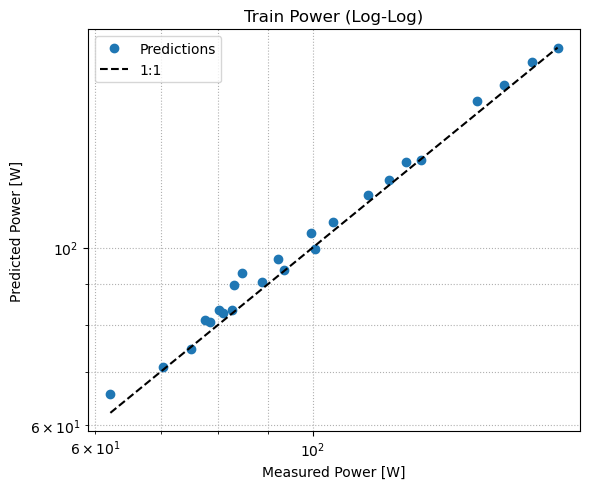

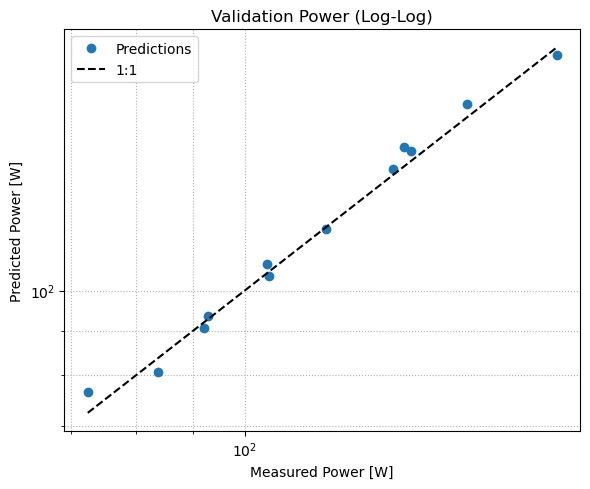

In [5]:
# Log-Log 图：功率预测 vs 数据
def plot_loglog(actual_power, pred_power, title, fname):
    actual_power = np.asarray(actual_power)
    pred_power = np.asarray(pred_power)
    lo = float(min(actual_power.min(), pred_power.min()))
    hi = float(max(actual_power.max(), pred_power.max()))
    plt.figure(figsize=(6,5))
    plt.loglog(actual_power, pred_power, 'o', label='Predictions')
    plt.loglog([lo, hi], [lo, hi], 'k--', label='1:1')
    plt.xlabel('Measured Power [W]')
    plt.ylabel('Predicted Power [W]')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle=':')
    plt.tight_layout()
    plt.savefig(fname, dpi=220)
    plt.show()

plot_loglog(train_true[:,1], train_pred[:,1], 'Train Power (Log-Log)', 'outputs/part1/train_power_loglog.png')
plot_loglog(val_true[:,1], val_pred[:,1], 'Validation Power (Log-Log)', 'outputs/part1/val_power_loglog.png')


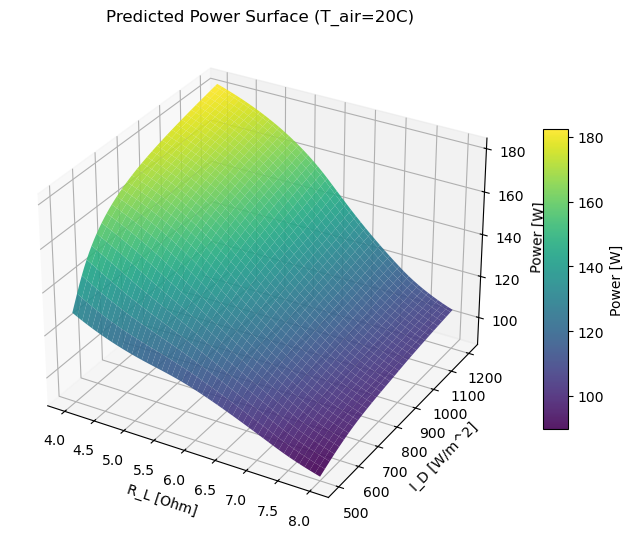

In [6]:
# (g) T_air=20C 时功率曲面图
rl_vals = np.linspace(4.0, 8.0, 50)
id_vals = np.linspace(500.0, 1200.0, 60)
RL, ID = np.meshgrid(rl_vals, id_vals)
TA = np.full_like(RL, 20.0)
inputs = np.stack([TA, ID, RL], axis=-1)
inputs_norm = inputs / x_median
pred_norm = model.predict(inputs_norm.reshape(-1,3), verbose=0)
pred_w = denorm(pred_norm)[:,1].reshape(RL.shape)

fig = plt.figure(figsize=(7,5.5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(RL, ID, pred_w, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel('R_L [Ohm]')
ax.set_ylabel('I_D [W/m^2]')
ax.set_zlabel('Power [W]')
ax.set_title('Predicted Power Surface (T_air=20C)')
fig.colorbar(surf, shrink=0.6, aspect=12, label='Power [W]')
plt.tight_layout()
plt.savefig('outputs/part1/power_surface.png', dpi=220)
plt.show()


MSE epochs run: 6000
MSE best mse: 4.6984529035398737e-05
MSE final loss: 0.0004731185326818377
rms error = sqrt(best mse): 0.006854526171472302


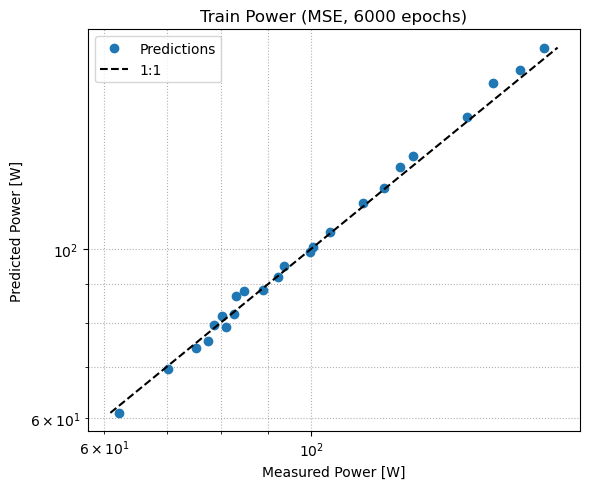

MSE metrics saved to outputs/part1/mse_metrics.json


In [7]:
# Task 3.1.2 (a)(b): MSE 基准运行 6000 epochs，无提前停止
initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
model_mse = Sequential([
    Dense(6, activation=K.elu, input_shape=[3], kernel_initializer=initializer),
    Dense(12, activation=K.elu, kernel_initializer=initializer),
    Dense(6, activation=K.elu, kernel_initializer=initializer),
    Dense(2, kernel_initializer=initializer)
])
rms_mse = RMSprop(0.010)
model_mse.compile(loss='mean_squared_error', optimizer=rms_mse)
history_mse = model_mse.fit(x_train, y_train, epochs=6000, batch_size=8, verbose=0)
best_mse = float(np.min(history_mse.history['loss']))
final_mse = float(history_mse.history['loss'][-1])
rms_error = float(np.sqrt(best_mse))
print('MSE epochs run:', len(history_mse.history['loss']))
print('MSE best mse:', best_mse)
print('MSE final loss:', final_mse)
print('rms error = sqrt(best mse):', rms_error)

train_mse_pred = model_mse.predict(x_train, verbose=0)
train_mse_pred_den = denorm(train_mse_pred)
train_mse_true_den = denorm(y_train)

plot_loglog(train_mse_true_den[:,1], train_mse_pred_den[:,1],
           'Train Power (MSE, 6000 epochs)', 'outputs/part1/mse_train_power_loglog.png')

import pathlib, json
mse_metrics = {
    'final_loss': final_mse,
    'best_mse': best_mse,
    'rms_error': rms_error,
}
pathlib.Path('outputs/part1/mse_metrics.json').write_text(json.dumps(mse_metrics, indent=2))
print('MSE metrics saved to outputs/part1/mse_metrics.json')


M4E epochs run: 6000
M4E best m4e: 7.711149940803352e-09
M4E final loss: 1.111844749601687e-08
r4s error = sqrt(sqrt(best m4e)): 0.009370867279771695


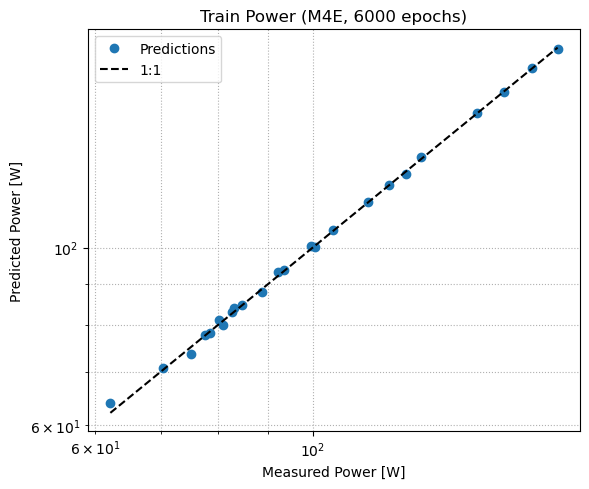

M4E metrics saved to outputs/part1/m4e_metrics.json


In [8]:
# Task 3.1.2 (c): 自定义 M4E 损失，6000 epochs，无提前停止
def mean_double_squared_error(y_true, y_pred):
    diff = y_pred - y_true
    return K.mean(K.square(diff) * K.square(diff))

initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
model_m4e = Sequential([
    Dense(6, activation=K.elu, input_shape=[3], kernel_initializer=initializer),
    Dense(12, activation=K.elu, kernel_initializer=initializer),
    Dense(6, activation=K.elu, kernel_initializer=initializer),
    Dense(2, kernel_initializer=initializer)
])
model_m4e.compile(optimizer='rmsprop', loss=mean_double_squared_error)
history_m4e = model_m4e.fit(x_train, y_train, epochs=6000, batch_size=8, verbose=0)
best_m4e = float(np.min(history_m4e.history['loss']))
final_m4e = float(history_m4e.history['loss'][-1])
r4s_error = float(best_m4e ** 0.25)
print('M4E epochs run:', len(history_m4e.history['loss']))
print('M4E best m4e:', best_m4e)
print('M4E final loss:', final_m4e)
print('r4s error = sqrt(sqrt(best m4e)):', r4s_error)

train_m4e_pred = model_m4e.predict(x_train, verbose=0)
train_m4e_pred_den = denorm(train_m4e_pred)
train_m4e_true_den = denorm(y_train)

plot_loglog(train_m4e_true_den[:,1], train_m4e_pred_den[:,1],
           'Train Power (M4E, 6000 epochs)', 'outputs/part1/m4e_train_power_loglog.png')

import pathlib, json
m4e_metrics = {
    'final_loss': final_m4e,
    'best_m4e': best_m4e,
    'r4s_error': r4s_error,
}
pathlib.Path('outputs/part1/m4e_metrics.json').write_text(json.dumps(m4e_metrics, indent=2))
print('M4E metrics saved to outputs/part1/m4e_metrics.json')
